In [23]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from dataprocess import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch.nn.init as init
from torch.utils.data import Dataset
import logging

In [24]:
from SiamessGNN import *
from dataprocess import *

为了构造一个预测相似性得分的函数，我们可以利用训练时正负样本的欧几里得距离数据来定义一个合理的相似性得分函数。根据数据，正样本的欧几里得距离均值大约在70左右，而负样本的欧几里得距离均值大约在300左右。我们可以利用这些信息来设计一个相似性得分函数，使得得分在0到1之间，且越接近1表示相似性越高。

使用一个基于欧几里得距离的相似性得分函数，将距离映射到0到1之间。具体来说，可以使用以下公式：

$$similarity_score= \frac{1}{1+α⋅distance}$$

其中，α 是一个缩放因子，用于调整距离对相似性得分的影响。接下来参考正负样本的距离分布来计算合适的α值

假设我们希望正样本的相似性得分在0.8到1之间，负样本的相似性得分在0到0.2之间。
对于正样本，距离均值为70，我们希望相似性得分在0.8到1之间：
$$0.8≤ \frac{1}{1+α⋅120} ≤1$$
解得：
$$α≈0.0035$$

对于负样本，距离均值为300，我们希望相似性得分在0到0.5之间：
$$0≤ \frac{1}{1+α⋅300} ≤0.5$$
解得：
$$α≈0.0033$$

因此，可以选择一个 α 值在0.0033到0.0035之间，例如可以设定α≈0.0034，设计函数如下

In [25]:
def similarity_score(emb1, emb2, alpha=0.0023):
    """
    计算两个嵌入向量的相似性得分
    :param emb1: 第一个图的嵌入向量
    :param emb2: 第二个图的嵌入向量
    :param alpha: 缩放因子，默认为0.0023
    :return: 相似性得分 (0-1)
    """
    distance = torch.norm(emb1 - emb2, p=2, dim=1)  # 计算欧几里得距离
    score = 1 / (1 + alpha * distance)  # 计算相似性得分
    return score  # 返回整个相似性得分张量

In [26]:
import numpy as np
import logging
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def fin_evaluate(model, loader, loss_fn, device, epoch, alpha=0.0023 ,threshold=0.5, logger=None):
    """
    评估函数，计算验证集上的损失、相似性得分、准确率、F1 分数等指标。
    :param model: 模型
    :param loader: 数据加载器 (val_loader)
    :param loss_fn: 损失函数
    :param device: 设备 (CPU/GPU)
    :param epoch: 当前 epoch
    :param alpha: 相似性得分函数的缩放因子
    :param threshold: 分类阈值，默认为 0.5
    :param logger: 用于记录日志的 logger 对象
    :return: 平均损失、准确率、F1 分数、精确率、召回率
    """
    model.eval()
    total_loss = 0
    all_labels = []  # 存储真实标签
    all_predictions = []  # 存储预测标签
    similarity_scores = []  # 存储相似性得分

    pos_distances = []  # 存储正样本的欧几里得距离
    neg_distances = []  # 存储负样本的欧几里得距离
    with torch.no_grad():
        for data1, data2, data3 in loader:
            # 将数据移动到设备上
            data1, data2, data3 = data1.to(device), data2.to(device), data3.to(device)

            # 获取嵌入向量
            emb1 = model.encoder(data1.x, data1.edge_index, data1.batch)
            emb2 = model.encoder(data2.x, data2.edge_index, data2.batch)
            emb3 = model.encoder(data3.x, data3.edge_index, data3.batch)

            # 计算三元组损失
            loss = loss_fn(emb1, emb2, emb3)
            total_loss += loss.item()

            # 计算欧几里得距离并收集
            pos_distance = torch.norm(emb1 - emb2, p=2, dim=1).detach().cpu().numpy()
            neg_distance = torch.norm(emb1 - emb3, p=2, dim=1).detach().cpu().numpy()
            pos_distances.extend(pos_distance)
            neg_distances.extend(neg_distance)

            # 计算相似性得分
            pos_score = similarity_score(emb1, emb2, alpha)  # 正样本相似性得分
            neg_score = similarity_score(emb1, emb3, alpha)  # 负样本相似性得分

            # 将相似性得分和标签存储
            similarity_scores.extend(pos_score.cpu().numpy().tolist())
            similarity_scores.extend(neg_score.cpu().numpy().tolist())
            all_labels.extend([1] * len(pos_score))  # 正样本标签为 1
            all_labels.extend([0] * len(neg_score))  # 负样本标签为 0

            # 根据阈值分类
            pos_predictions = (pos_score >= threshold).int().cpu().numpy().tolist()
            neg_predictions = (neg_score < threshold).int().cpu().numpy().tolist()
            all_predictions.extend(pos_predictions)
            all_predictions.extend(neg_predictions)

    # 计算平均损失
    avg_loss = total_loss / len(loader)

    # 计算正负样本的欧几里得距离统计信息
    pos_dist_mean = np.mean(pos_distances)
    pos_dist_min = np.min(pos_distances)
    pos_dist_max = np.max(pos_distances)

    neg_dist_mean = np.mean(neg_distances)
    neg_dist_min = np.min(neg_distances)
    neg_dist_max = np.max(neg_distances)

    # 输出日志记录正负样本的欧几里得距离统计
    if logger:
        logger.info(f"Epoch {epoch + 1}: Total Positive Distance - Mean: {pos_dist_mean:.4f}, Min: {pos_dist_min:.4f}, Max: {pos_dist_max:.4f}")
        logger.info(f"Epoch {epoch + 1}: Total Negative Distance - Mean: {neg_dist_mean:.4f}, Min: {neg_dist_min:.4f}, Max: {neg_dist_max:.4f}")

    # 计算分类指标
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)

    # 输出日志记录分类指标
    if logger:
        logger.info(f"Epoch {epoch + 1}: Val Loss: {avg_loss:.4f}")
        logger.info(f"Epoch {epoch + 1}: Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    return avg_loss, accuracy, f1, precision, recall


In [17]:

# 参数
input_dim = 139  # 节点特征维度
hidden_dim1 = 256
hidden_dim2 = 512
output_dim = 256
margin = 20
batch_size = 16
epochs = 10
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

log_file="./evaluate.log"

loss_fn = TripletLoss(margin)
# 读取数据集
csv_file = "./dataset/acfg.csv"
model_path = "./BinbertModels/triplet_model_epoch_2.pth"
print("start dataprocess...")
#train_loader, val_loader = prepare_datasets       (csv_file, model_path, device, test_size=0.2, batch_size=batch_size)
train_loader, val_loader = prepare_triplet_datasets(csv_file, model_path, device, test_size=0.2, batch_size=batch_size)
print("finish dataprocess...")





start dataprocess...


/autodl-fs/data/SiamessNN/dataprocess.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Finish data reading.
Generating triplets...


Processing groups: 100%|██████████| 546521/546521 [13:19<00:00, 683.34it/s]  


生成的三元组数量: 80000
finish dataprocess...


In [19]:

def save_dataloader_to_file(dataloader, file_path):
    """
    将 dataloader 中的数据保存到文件
    :param dataloader: 需要保存的 DataLoader
    :param file_path: 保存的文件路径
    """
    data_list = []
    for data1, data2, data3 in dataloader:
        # 将数据加载到 CPU，并转换为 numpy 数组或者 Tensor
        data1 = data1.cpu()
        data2 = data2.cpu()
        data3 = data3.cpu()
        
        # 将每个批次的数据保存到列表中
        data_list.append((data1, data2, data3))
    
    # 保存整个数据集
    torch.save(data_list, file_path)
    print(f"Data saved to {file_path}")

# 假设你已经有了 val_loader
val_loader_file = "./saved_val_loader.pth"
save_dataloader_to_file(val_loader, val_loader_file)


Data saved to ./saved_val_loader.pth


In [20]:
for epoch in range(5, 10):  # 对模型 1 到 10 进行评估
    model_path = f'./model/SiameseGNN/TripletGNN_epoch_{epoch+1}.pth'
    # 加载模型
    encoder = GraphEncoder(input_dim, hidden_dim1,hidden_dim2, output_dim)
    model = SiameseGNN(encoder).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    setup_logger(log_file)
    logger = logging.getLogger()
    logger.info(f"Evaluating Model: {model_path}")
    fin_evaluate(model, val_loader, loss_fn, device, epoch, alpha=0.0023, threshold=0.5,logger=logger)

/tmp/ipykernel_1473/4191449671.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
2025-02-10 13:29:09,992 - INFO - Evaluating 

In [37]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging

def visualize_distances(pos_distances, neg_distances, epoch):
    """
    可视化正负样本的欧几里得距离分布
    :param pos_distances: 正样本的欧几里得距离
    :param neg_distances: 负样本的欧几里得距离
    :param epoch: 当前 epoch，用于标题
    """
    plt.figure(figsize=(10, 6))
    
    # 绘制正样本的欧氏距离分布
    sns.histplot(pos_distances, kde=True, color='blue', label='Positive Samples', stat='density', bins=30)
    
    # 绘制负样本的欧氏距离分布
    sns.histplot(neg_distances, kde=True, color='red', label='Negative Samples', stat='density', bins=30)
    
    # 添加图例
    plt.legend()
    
    # 添加标题和标签
    plt.title(f'Epoch {epoch}: Distribution of Euclidean Distances')
    plt.xlabel('Euclidean Distance')
    plt.ylabel('Density')
    
    # 显示图形
    plt.show()

def visualize_scatter(pos_distances, neg_distances, epoch):
    """
    可视化正负样本的欧几里得距离分布（散点图）
    :param pos_distances: 正样本的欧几里得距离
    :param neg_distances: 负样本的欧几里得距离
    :param epoch: 当前 epoch，用于标题
    """
    plt.figure(figsize=(10, 6))
    
    # 绘制正样本的散点图
    plt.scatter(range(len(pos_distances)), pos_distances, color='blue', label='Positive Samples', alpha=0.6)
    
    # 绘制负样本的散点图
    plt.scatter(range(len(neg_distances)), neg_distances, color='red', label='Negative Samples', alpha=0.6)
    
    # 添加标题、标签和图例
    plt.title(f'Epoch {epoch}: Scatter Plot of Euclidean Distances')
    plt.xlabel('Sample Index')
    plt.ylabel('Euclidean Distance')
    plt.legend()
    
    # 显示图形
    plt.show()

def fin_visualize(model, loader, loss_fn, device, epoch=8):
    """
    评估并可视化指定 epoch 的模型
    :param model: 模型
    :param loader: 数据加载器 (val_loader)
    :param loss_fn: 损失函数
    :param device: 设备 (CPU/GPU)
    :param epochs: 要评估的 epoch 范围
    """

    model_path = f'./model/SiameseGNN/TripletGNN_epoch_{epoch}.pth'
    # 加载模型
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    pos_distances = []  # 存储正样本的欧几里得距离
    neg_distances = []  # 存储负样本的欧几里得距离
    total_loss = 0
    
    with torch.no_grad():
        for data1, data2, data3 in loader:
            data1, data2, data3 = data1.to(device), data2.to(device), data3.to(device)

            # 获取嵌入向量
            emb1 = model.encoder(data1.x, data1.edge_index, data1.batch)
            emb2 = model.encoder(data2.x, data2.edge_index, data2.batch)
            emb3 = model.encoder(data3.x, data3.edge_index, data3.batch)

            # 计算三元组损失
            loss = loss_fn(emb1, emb2, emb3)
            total_loss += loss.item()

            # 计算欧几里得距离并收集
            pos_distance = torch.norm(emb1 - emb2, p=2, dim=1).detach().cpu().numpy()
            neg_distance = torch.norm(emb1 - emb3, p=2, dim=1).detach().cpu().numpy()
            pos_distances.extend(pos_distance)
            neg_distances.extend(neg_distance)

        # 可视化欧氏距离
        visualize_distances(pos_distances, neg_distances, epoch)
        visualize_scatter(pos_distances, neg_distances, epoch)
        # 输出损失值
        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch} - Avg Loss: {avg_loss:.4f}")

In [38]:
# 参数
input_dim = 139  # 节点特征维度
hidden_dim1 = 256
hidden_dim2 = 512
output_dim = 256
margin = 20
batch_size = 16
epochs = 10
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

log_file="./evaluate.log"

loss_fn = TripletLoss(margin)
model_path = "./BinbertModels/triplet_model_epoch_2.pth"
print("start dataprocess...")
val_loader_file = "./saved_val_loader.pth"
val_loader = torch.load(val_loader_file)

start dataprocess...


/tmp/ipykernel_1473/3396527233.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_loader = torch.load(val_loader_file)


/tmp/ipykernel_1473/1666371402.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


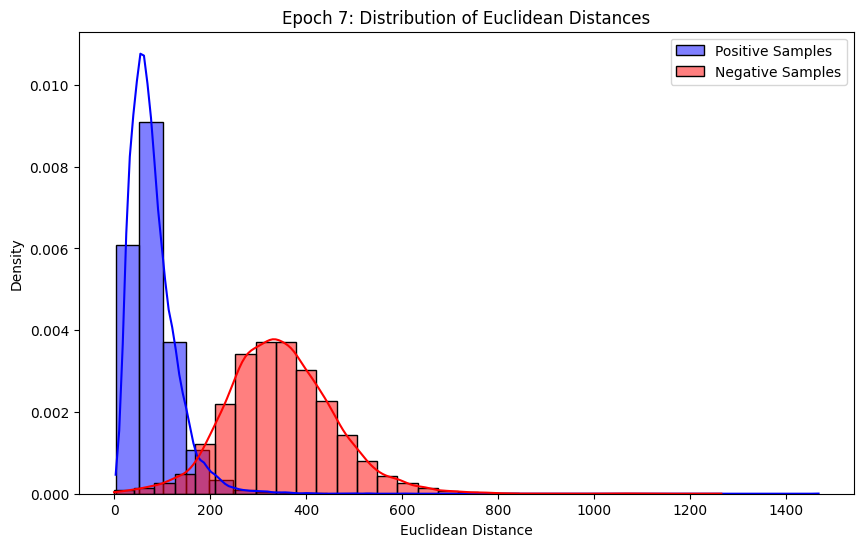

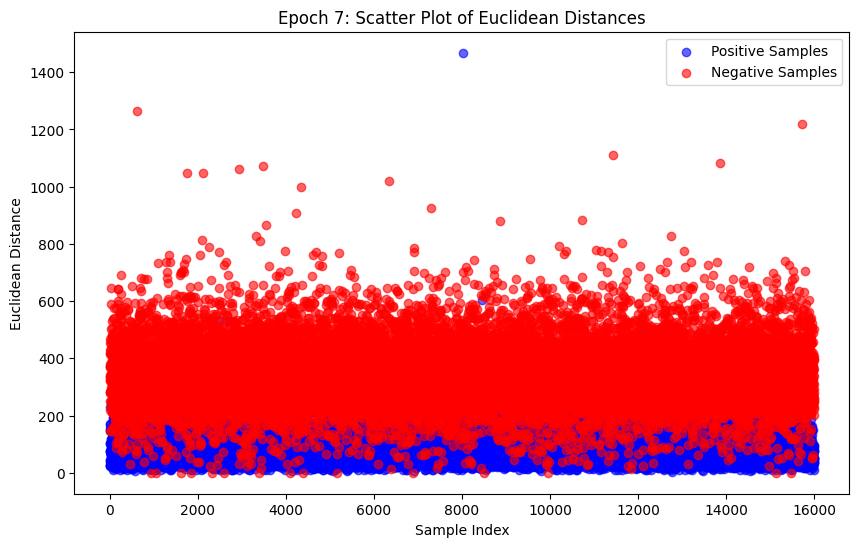

Epoch 7 - Avg Loss: 0.8251


In [41]:
fin_visualize(model, val_loader, loss_fn, device, epoch=7)

/tmp/ipykernel_1473/1666371402.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


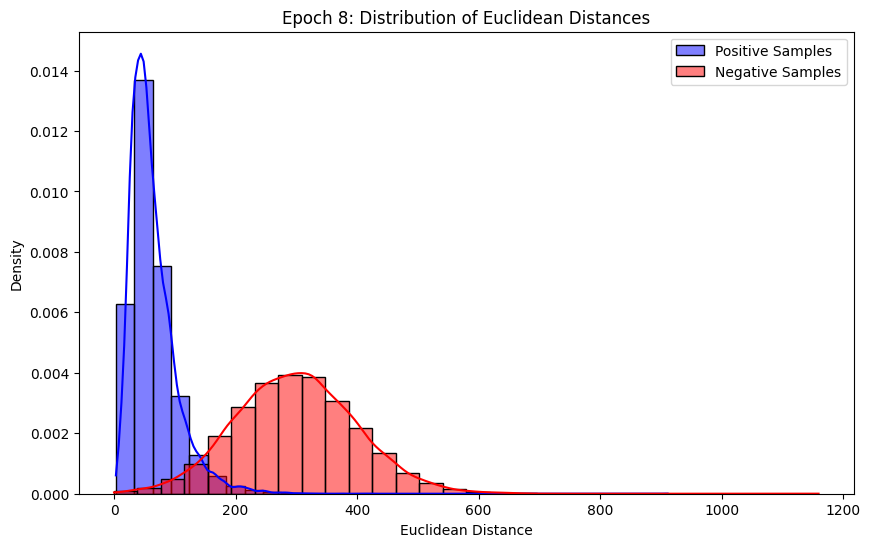

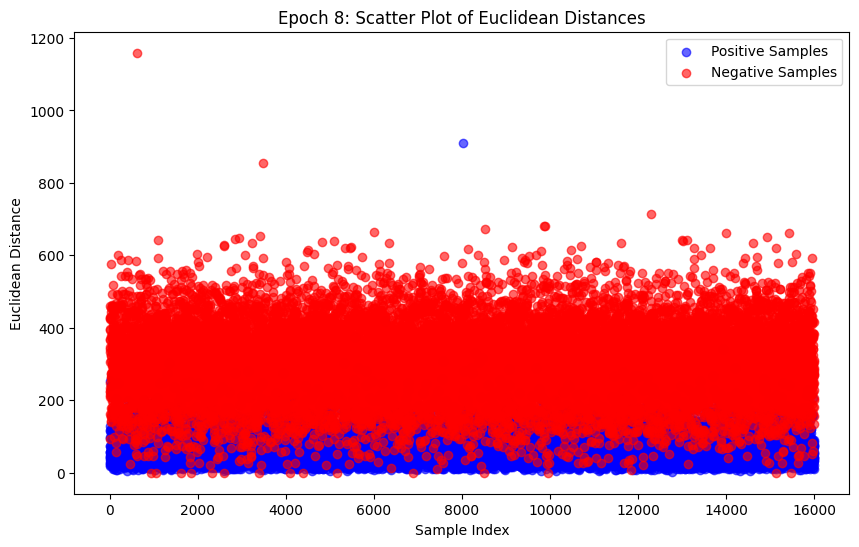

Epoch 8 - Avg Loss: 0.6594


In [39]:

fin_visualize(model, val_loader, loss_fn, device, epoch=8)


/tmp/ipykernel_1473/1666371402.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


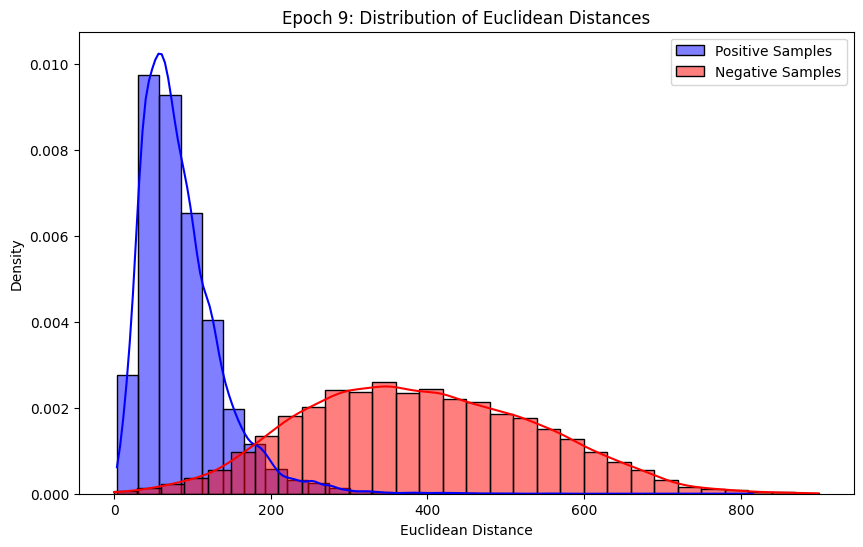

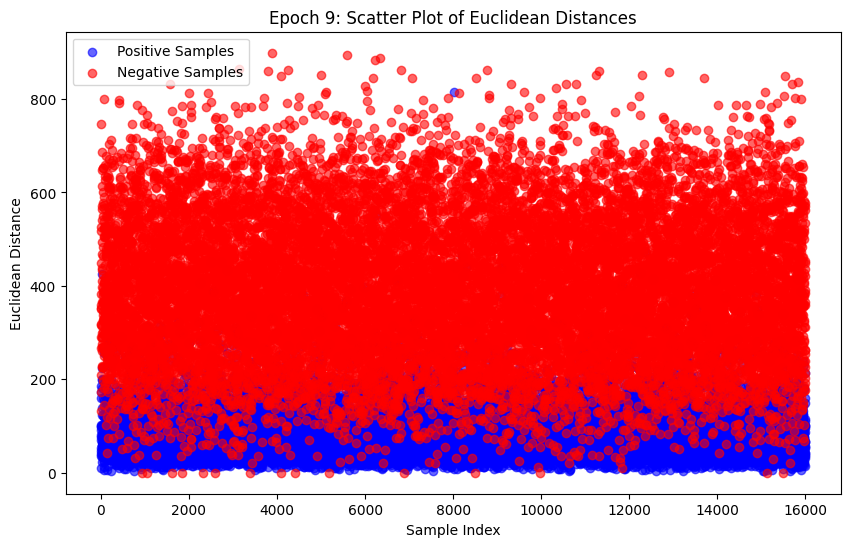

Epoch 9 - Avg Loss: 0.8646


In [40]:
fin_visualize(model, val_loader, loss_fn, device, epoch=9)

In [45]:
model_path = f'./model/SiameseGNN/TripletGNN_epoch_{8}.pth'
# 加载模型
encoder = GraphEncoder(input_dim, hidden_dim1,hidden_dim2, output_dim)
model = SiameseGNN(encoder).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
setup_logger(log_file)
logger = logging.getLogger()
logger.info(f"Evaluating Model: {model_path}")
fin_evaluate(model, val_loader, loss_fn, device, epoch, alpha=0.001, threshold=0.5,logger=logger)

/tmp/ipykernel_1473/4167239167.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
2025-02-10 14:37:12,573 - INFO - Evaluating 

(0.6594099442958832, 0.99996875, 0.9999687509765319, 0.9999375039060059, 1.0)